# Using `gwent` to Generate Source Characteristic Strain Curves

Here we show examples of using the different classes in `gwent` for various black holes binaries (BHBs), both in the frequency and time domain.

First, we load important packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os,sys

import matplotlib as mpl
import matplotlib.pyplot as plt

from cycler import cycler
from scipy.constants import golden_ratio

import astropy.constants as const
import astropy.units as u

import gwent
import gwent.detector as detector
import gwent.binary as binary
import gwent.snr as snr

#Turn off warnings for tutorial
import warnings
warnings.filterwarnings('ignore')

Setting matplotlib and plotting preferences

In [3]:
def get_fig_size(width=7,scale=1.0):
    #width = 3.36 # 242 pt
    base_size = np.array([1, 1/scale/golden_ratio])
    fig_size = width * base_size
    return(fig_size)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = get_fig_size()
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
color_cycle_wong = ['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle_wong)

We need to get the file directories to load in the instrument files.

In [4]:
load_directory = gwent.__path__[0] + '/LoadFiles'

## Initialize different instruments

To compare BHB strains and assess their detectability, we load in a few example detectors. For more information about loading instruments, see the tutorial on detectors.


### NANOGrav 11yr Characteristic Strain

Using real NANOGrav 11yr data put through `hasasia`

In [5]:
NANOGrav_filedirectory = load_directory + '/InstrumentFiles/NANOGrav/StrainFiles/' 
NANOGrav_11yr_hasasia_file = NANOGrav_filedirectory + 'NANOGrav_11yr_S_eff.txt'
NANOGrav_11yr_hasasia = detector.PTA('NANOGrav 11yr',load_location=NANOGrav_11yr_hasasia_file,I_type='E')
NANOGrav_11yr_hasasia.T_obs = 11.4*u.yr

### LISA Proposal 1

Values taken from the ESA L3 proposal, Amaro-Seaone, et al., 2017 (https://arxiv.org/abs/1702.00786)

In [6]:
L = 2.5*u.Gm  #armlength in Gm
L = L.to('m')
LISA_T_obs = 4*u.yr

f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
A_acc = 3e-15*u.m/u.s/u.s
A_IMS = 10e-12*u.m

Background = False

LISA_prop1 = detector.SpaceBased('LISA',\
                          LISA_T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                          Background=Background)

### aLIGO

In [7]:
Ground_T_obs = 4*u.yr
#aLIGO
aLIGO_filedirectory = load_directory + '/InstrumentFiles/aLIGO/'
aLIGO_1_filename = 'aLIGODesign.txt'

aLIGO_1_filelocation = aLIGO_filedirectory + aLIGO_1_filename

aLIGO_1 = detector.GroundBased('aLIGO 1',Ground_T_obs,load_location=aLIGO_1_filelocation,I_type='A')

## Generating Binary Black Holes with `gwent` in the Frequency Domain

We start with BHB parameters that exemplify the range of IMRPhenomD's waveforms from Khan, et al. 2016 https://arxiv.org/abs/1508.07253 and Husa, et al. 2016 https://arxiv.org/abs/1508.07250 

In [8]:
M = [1e6,65.0,1e10]
q = [1.0,18.0,1.0]
x1 = [0.95,0.0,-0.95]
x2 = [0.95,0.0,-0.95]
z = [3.0,0.093,20.0]

Uses the first parameter values that lie in the `LISA_prop1` detector band.

In [9]:
source_1 = binary.BBHFrequencyDomain(M[0],q[0],z[0],x1[0],x2[0])

Uses the second parameter values that lie in the `aLIGO` detector band.

In [10]:
source_2 = binary.BBHFrequencyDomain(M[1],q[1],z[1],x1[1],x2[1])

Uses the third parameter values that lie in the `NANOGrav_11yr_hasasia` detector band.

In [11]:
source_3 = binary.BBHFrequencyDomain(M[2],q[2],z[2],x1[2],x2[2])

## How to Get Information about BHB

### Find out source 1's frequency given some time from merger.

In [12]:
print("Source frequency 10 years prior to merger in Observer frame: ",
      source_1.Get_Source_Freq(10*u.yr,frame='observer'))
print("Source frequency 10 years prior to merger in Source frame: ",
      source_1.Get_Source_Freq(10*u.yr,frame='source'))

Source frequency 10 years prior to merger in Observer frame:  4.9371229709723884e-05 1 / s
Source frequency 10 years prior to merger in Source frame:  2.9356308823618684e-05 1 / s


### Find out source 2's time to merger from a given frequency.

In [13]:
print("Time from merger for BHB with GW frequency of 1/minute (~17mHz) in the Observer frame: ",
      source_2.Get_Time_From_Merger(1/u.minute,frame='observer').to('yr'))
print("Time from merger for BHB with GW frequency of 1/minute (~17mHz) in the Source frame: ",
      source_2.Get_Time_From_Merger(1/u.minute,frame='source').to('yr'))

Time from merger for BHB with GW frequency of 1/minute (~17mHz) in the Observer frame:  17.032270309184458 yr
Time from merger for BHB with GW frequency of 1/minute (~17mHz) in the Source frame:  21.59034784914432 yr


### Find out source 3's observed frequency given some evolved time. 
And whether the source is monochromatic or chirping for the evolved time in the observer frame.

In [14]:
#First we have to give the source some initial frequency
source_3.f_gw = 8*u.nHz

source_3.Check_Freq_Evol(T_evol=5*u.yr,T_evol_frame='observer')
print("Observed frequency after 5 years of evolution in Observer frame: ",
      source_3.f_T_obs)
print("Does the source change a resolvable amount after evolving for 5 years in the Observer frame?: ",
      source_3.ismono)
print("\n")
source_3.Check_Freq_Evol(T_evol=5*u.yr,T_evol_frame='source')
print("Observed frequency after 5 years of evolution in Source frame: ",
      source_3.f_T_obs)
print("Does the source change a resolvable amount after evolving for 5 years in the Source frame?: ",
      source_3.ismono)

Observed frequency after 5 years of evolution in Observer frame:  1.7955629558729957e-08 1 / s
Does the source change a resolvable amount after evolving for 5 years in the Observer frame?:  True


Observed frequency after 5 years of evolution in Source frame:  5.732821260078733e-09 1 / s
Does the source change a resolvable amount after evolving for 5 years in the Source frame?:  True


We can set the instrument that "observes" the source. If you orginally assign the source an instrument (which we show in a bit), the initial frequency (`f_gw`) is set to the instrument's most sensitive frequency

In [15]:
source_3.instrument = NANOGrav_11yr_hasasia
source_3.Check_Freq_Evol()
print("Observed frequency after {}".format(np.max(source_3.instrument.T_obs.value)),
      "years of evolution in Observer frame: ",
      source_3.f_T_obs)

Observed frequency after 11.4 years of evolution in Observer frame:  1.3181810661218933e-08 1 / s


## Plots of Example GW Band

Displays only generated detectors: WN only PTAs, ESA L3 proposal LISA, aLIGO, and Einstein Telescope.

### Chirping Sources

Displays two sources' waveform throughout its observing run (from left to right: `NANOGrav_11yr_hasasia`,`LISA_prop1`,`ET`).

In [16]:
source_1_t_T_obs_f = source_1.Get_Source_Freq(LISA_prop1.T_obs.to('s'))/(1+source_1.z)
source_1_idx = np.abs(source_1.f-source_1_t_T_obs_f).argmin()

source_2_t_T_obs_f = source_2.Get_Source_Freq(aLIGO_1.T_obs.to('s'))/(1+source_2.z)
source_2_idx = np.abs(source_2.f-source_2_t_T_obs_f).argmin()

source_3_t_T_obs_f = source_3.Get_Source_Freq(NANOGrav_11yr_hasasia.T_obs.to('s'))/(1+source_3.z)
source_3_idx = np.abs(source_3.f-source_3_t_T_obs_f).argmin()

In [17]:
source_4 = binary.BBHFrequencyDomain(1e2,1.0,1.0,0.0,0.0)
source_5 = binary.BBHFrequencyDomain(1e8,1.0,0.1,0.0,0.0)

source_4.f_gw = LISA_prop1.f_opt
source_4_t_T_obs_f = source_4.Get_Source_Freq(aLIGO_1.T_obs,frame="observer")
idx4 = np.abs(source_4.f-source_4_t_T_obs_f).argmin()

source_5.f_gw = NANOGrav_11yr_hasasia.f_opt
source_5_t_T_obs_f = source_5.Get_Source_Freq(LISA_prop1.T_obs,frame="observer")
idx5 = np.abs(source_5.f-source_5_t_T_obs_f).argmin()

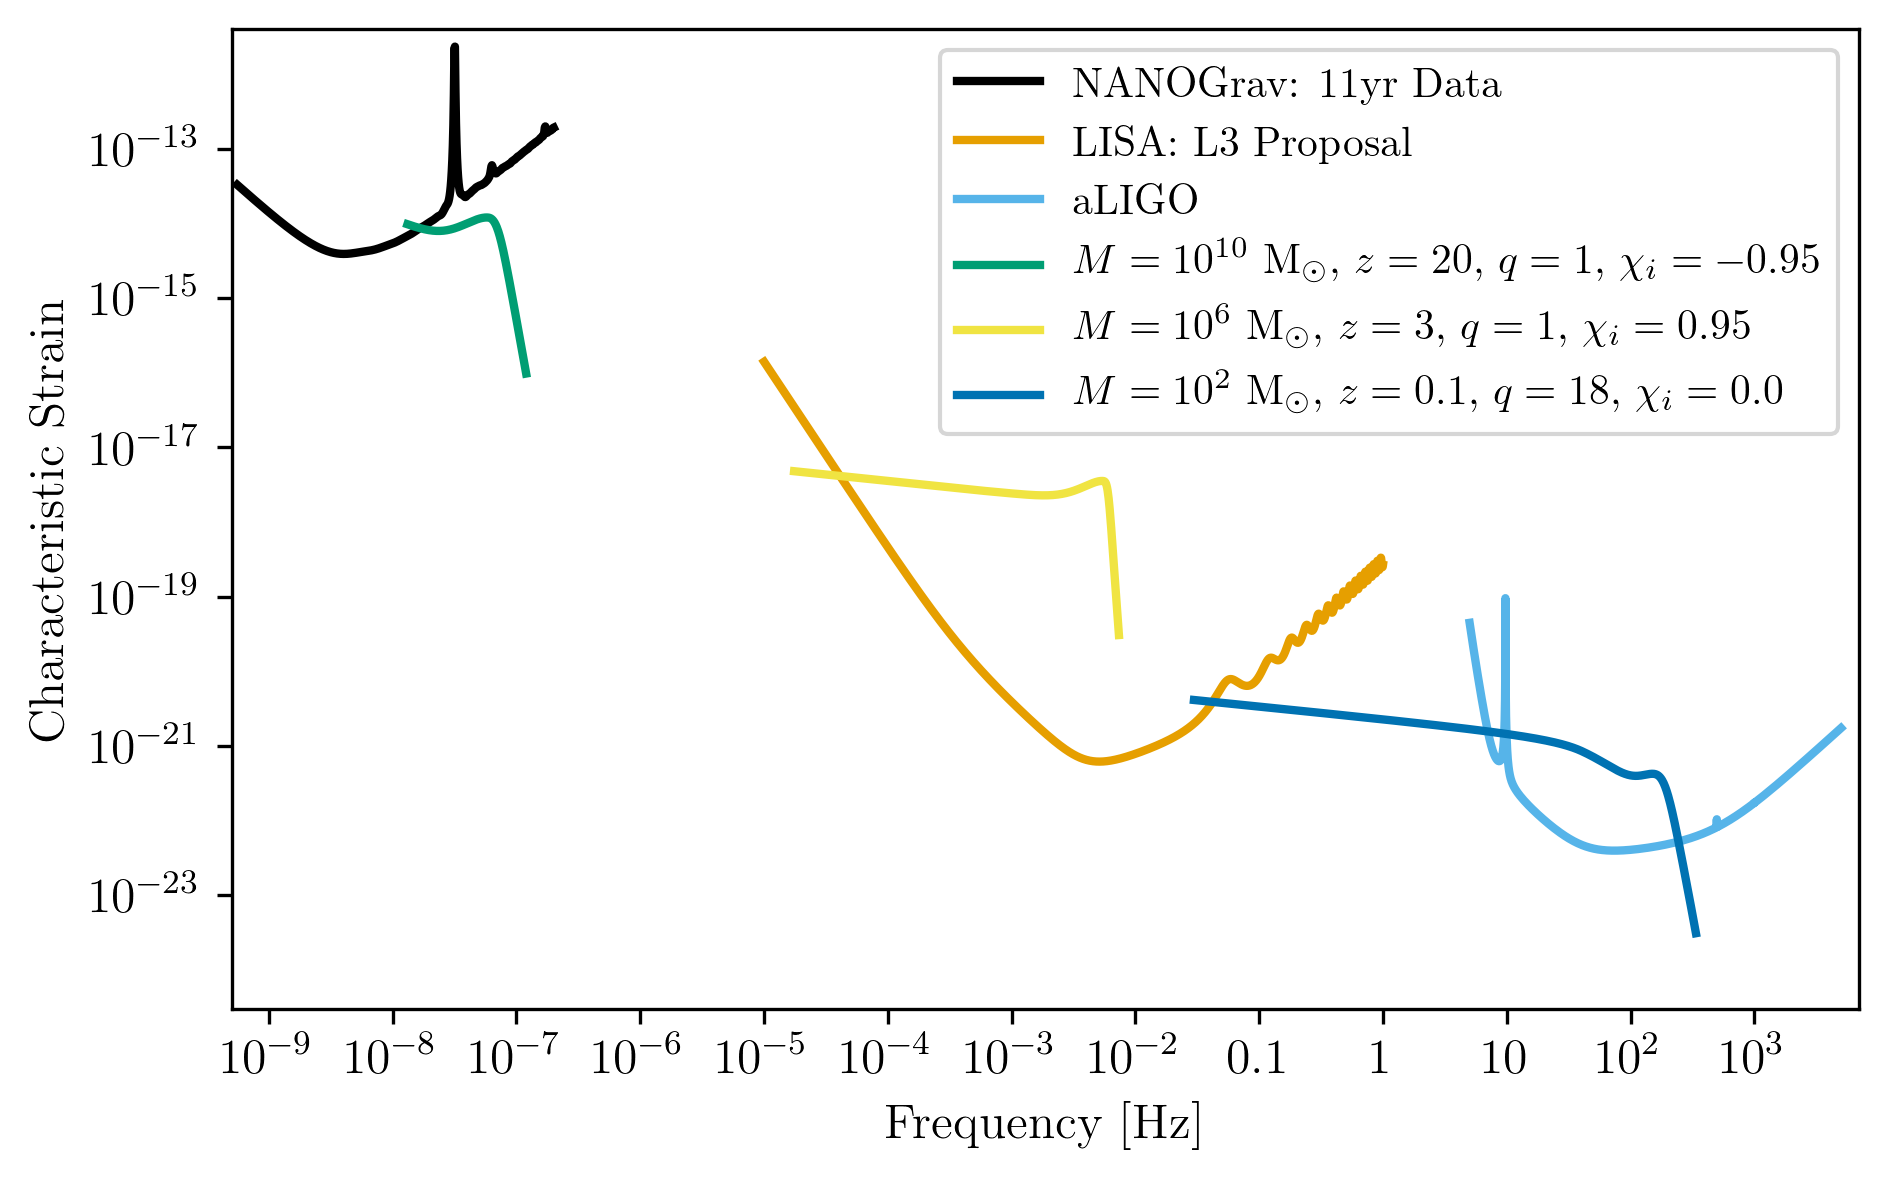

In [18]:
plt.figure(figsize=get_fig_size())

plt.loglog(NANOGrav_11yr_hasasia.fT,NANOGrav_11yr_hasasia.h_n_f,label='NANOGrav: 11yr Data')
plt.loglog(LISA_prop1.fT,LISA_prop1.h_n_f,label='LISA: L3 Proposal')
plt.loglog(aLIGO_1.fT,aLIGO_1.h_n_f,label='aLIGO')

plt.loglog(source_3.f[source_3_idx:],binary.Get_Char_Strain(source_3)[source_3_idx:],
          label=r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.0f$, $q = %.0f$, $\chi_{i} = %.2f$'
              %(np.log10(source_3.M.value),source_3.z,source_3.q,source_3.chi1))
plt.loglog(source_1.f[source_1_idx:],binary.Get_Char_Strain(source_1)[source_1_idx:],
          label=r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.0f$, $q = %.0f$, $\chi_{i} = %.2f$'
              %(np.log10(source_1.M.value),source_1.z,source_1.q,source_1.chi1))
plt.loglog(source_2.f[source_2_idx:],binary.Get_Char_Strain(source_2)[source_2_idx:],
          label=r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.1f$, $q = %.0f$, $\chi_{i} = %.1f$'
              %(np.log10(source_2.M.value),source_2.z,source_2.q,source_2.chi1))

xlabel_min = -10
xlabel_mplt = 5
xlabels = np.arange(xlabel_min,xlabel_mplt+1)
xlabels = xlabels[1::]

print_xlabels = []
for x in xlabels:
    if abs(x) > 1:
        print_xlabels.append(r'$10^{%i}$' %x)
    elif x == -1:
        print_xlabels.append(r'$%.1f$' %10.**x)
    else:
        print_xlabels.append(r'$%.0f$' %10.**x)
plt.xticks(10.**xlabels,print_xlabels)

plt.xlim([5e-10, 7e3])
plt.ylim([3e-25, 4e-12])

plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain')
plt.legend()
plt.show()

### Monochromatic Sources

Displays a comparison between two monochromatic strain sources, one equal mass, the other at a mass ratio of 18. The initial frequency is set by the NANOGrav 11yr at the detector's most sensitive frequency. The  NANOGrav  11yr  data in this plot corresponds to a source strain ($h_{0}$) with SNR of one;  note that this is not characteristic strain.

In [19]:
source_4 = binary.BBHFrequencyDomain(1e10,1.0,0.1,0.0,0.0,instrument=NANOGrav_11yr_hasasia)
source_5 = binary.BBHFrequencyDomain(1e10,18.0,0.1,0.0,0.0,instrument=NANOGrav_11yr_hasasia)

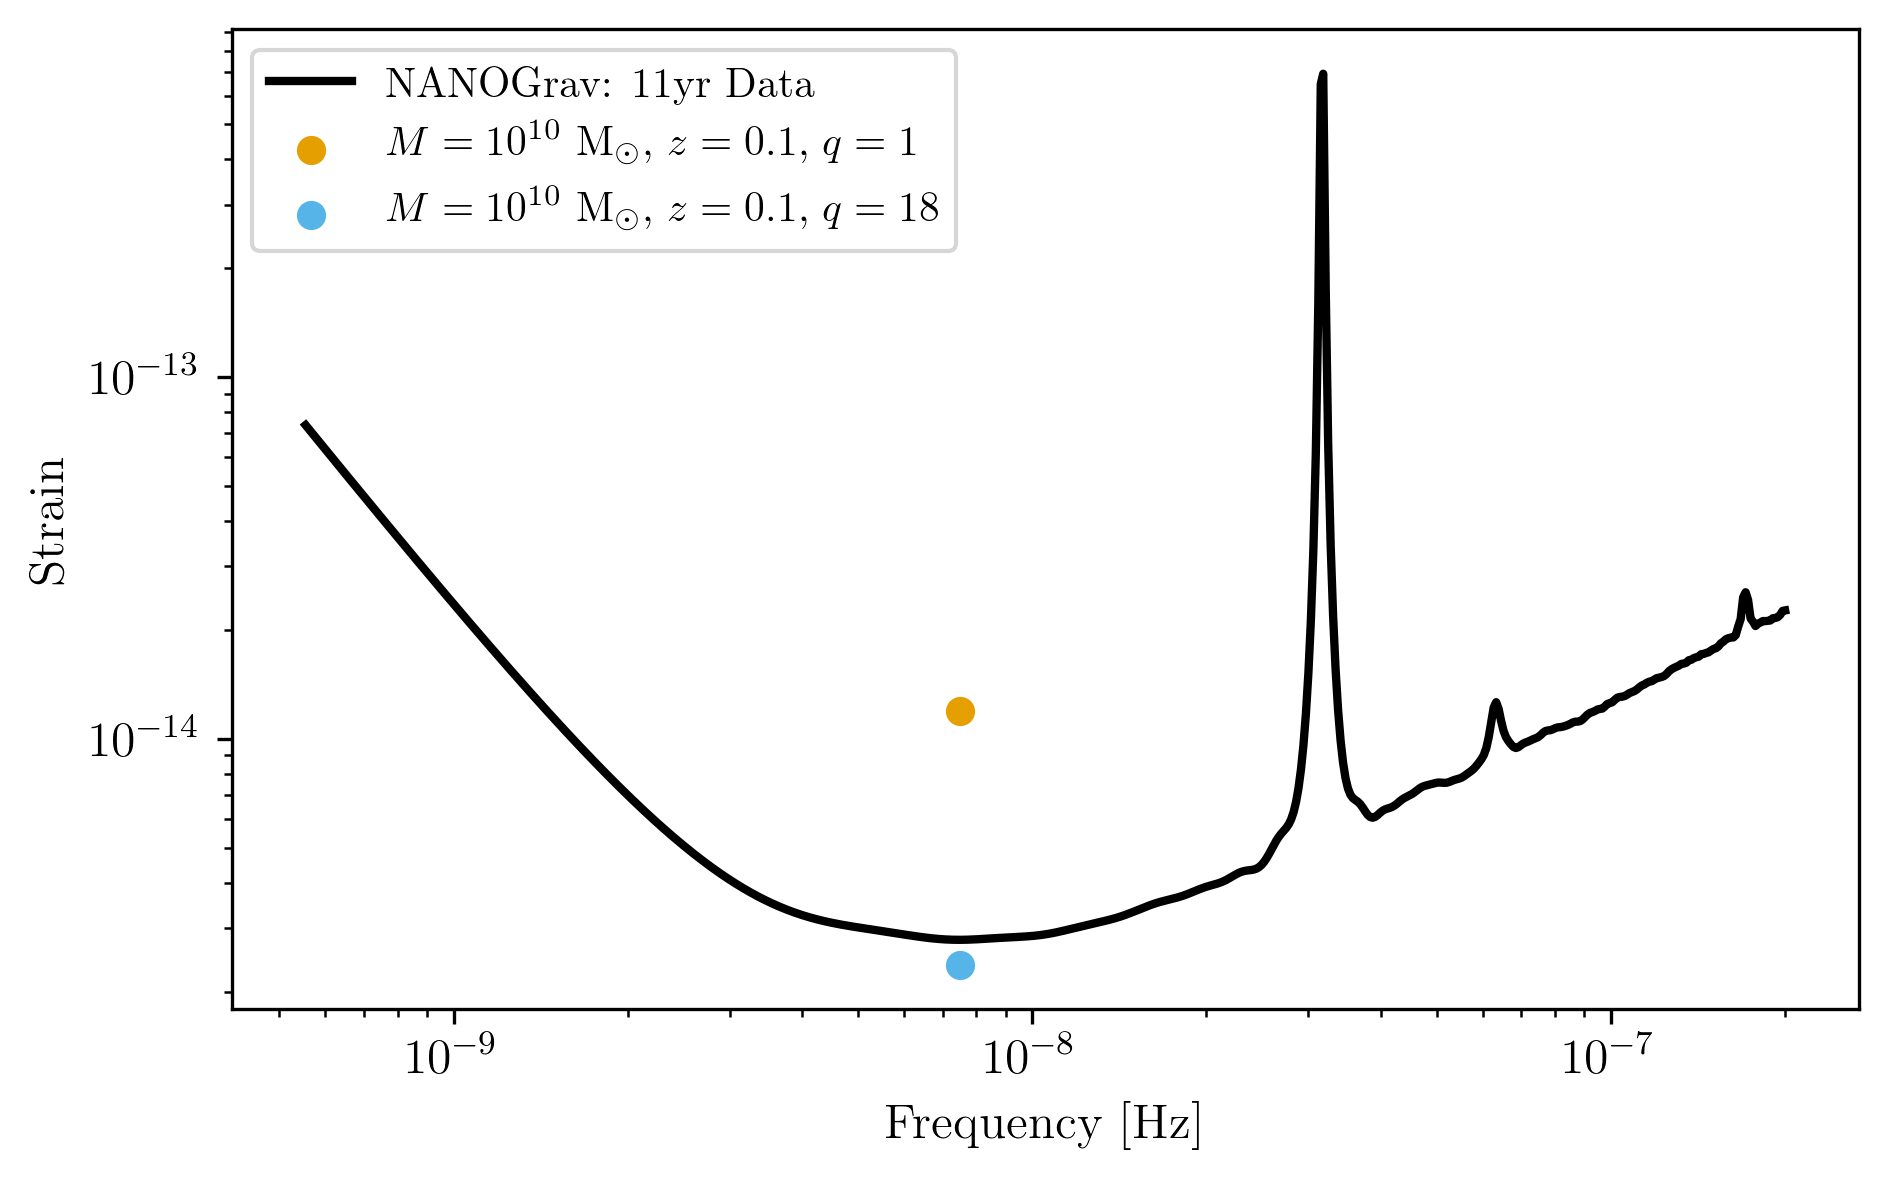

In [20]:
plt.figure(figsize=get_fig_size())

plt.loglog(NANOGrav_11yr_hasasia.fT,
           np.sqrt(NANOGrav_11yr_hasasia.S_n_f/np.max(np.unique(NANOGrav_11yr_hasasia.T_obs.to('s').value))),
           label=r'NANOGrav: 11yr Data')
plt.scatter(source_4.f_gw,
            source_4.h_gw,
            color='C1',
            label=r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.1f$, $q = %.0f$'
              %(np.log10(source_4.M.value),source_4.z,source_4.q))
plt.scatter(source_5.f_gw,
            source_5.h_gw,
            color='C2',
            label=r'$M = 10^{%.0f}$ $\mathrm{M}_{\odot}$, $z = %.1f$, $q = %.0f$'
              %(np.log10(source_5.M.value),source_5.z,source_5.q))

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain')
plt.legend(loc='upper left')
plt.show()

## Calculating the SNR
For the two sources displayed in the plot above, we will calculate the SNRs for monochromatic and chirping versions.

### Source 4: Monochromatic Case
Response in LISA data
First we set the source frequency. If you assign an instrument and not a frequency, `gwent` does this step internally and sets `f_gw` to the instruments optimal frequency (like we have done above too). 

In [21]:
snr.Calc_Mono_SNR(source_4,NANOGrav_11yr_hasasia)

<Quantity 4.28363792 Hz(2/3) s(2/3)>

One can also change the inclination of the source for calculating the monochromatic SNR.

In [22]:
snr.Calc_Mono_SNR(source_4,NANOGrav_11yr_hasasia,inc=np.pi/2)

<Quantity 2.39462639 Hz(2/3) s(2/3)>

### Source 2: Chirping Case
Response in aLIGO data

To set the start frequency of integration, you need to set the amount of time the instrument observes the source. This is done automatically for the given instrument.

In [23]:
snr.Calc_Chirp_SNR(source_2,aLIGO_1)

19.298875833998

### Source 1: Chirping Case
Response in LISA data

In [24]:
snr.Calc_Chirp_SNR(source_1,LISA_prop1)

3971.299610986342

Other ways this can be done is by setting the instrument's observation time or by using `binary.Check_Freq_Evol` and setting the optional `T_evol` parameter to the new observation time.

You can see in tis case, we have to drastically shorten the observed time to visibly change the SNR because the source waveform is so close to merger at the edge of LISA's frequency band.

In [25]:
source_1.Check_Freq_Evol(T_evol=1*u.hr)
snr.Calc_Chirp_SNR(source_1,LISA_prop1)

3962.951887907288

## Generate Frequency Data from Given Time Domain

Uses waveforms that are the difference between Effective One Body waveforms subtracted from Numerical Relativity waveforms for different harmonics.

This method and use is fairly untested, so proceed with caution and feel free to help out!

In [26]:
EOBdiff_filedirectory = load_directory + '/DiffStrain/EOBdiff/'
diff0002 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0002.dat')
diff0114 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0114.dat')
diff0178 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0178.dat')
diff0261 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0261.dat')
diff0303 = binary.BBHTimeDomain(M[1],q[0],z[1],load_location=EOBdiff_filedirectory+'diff0303.dat')

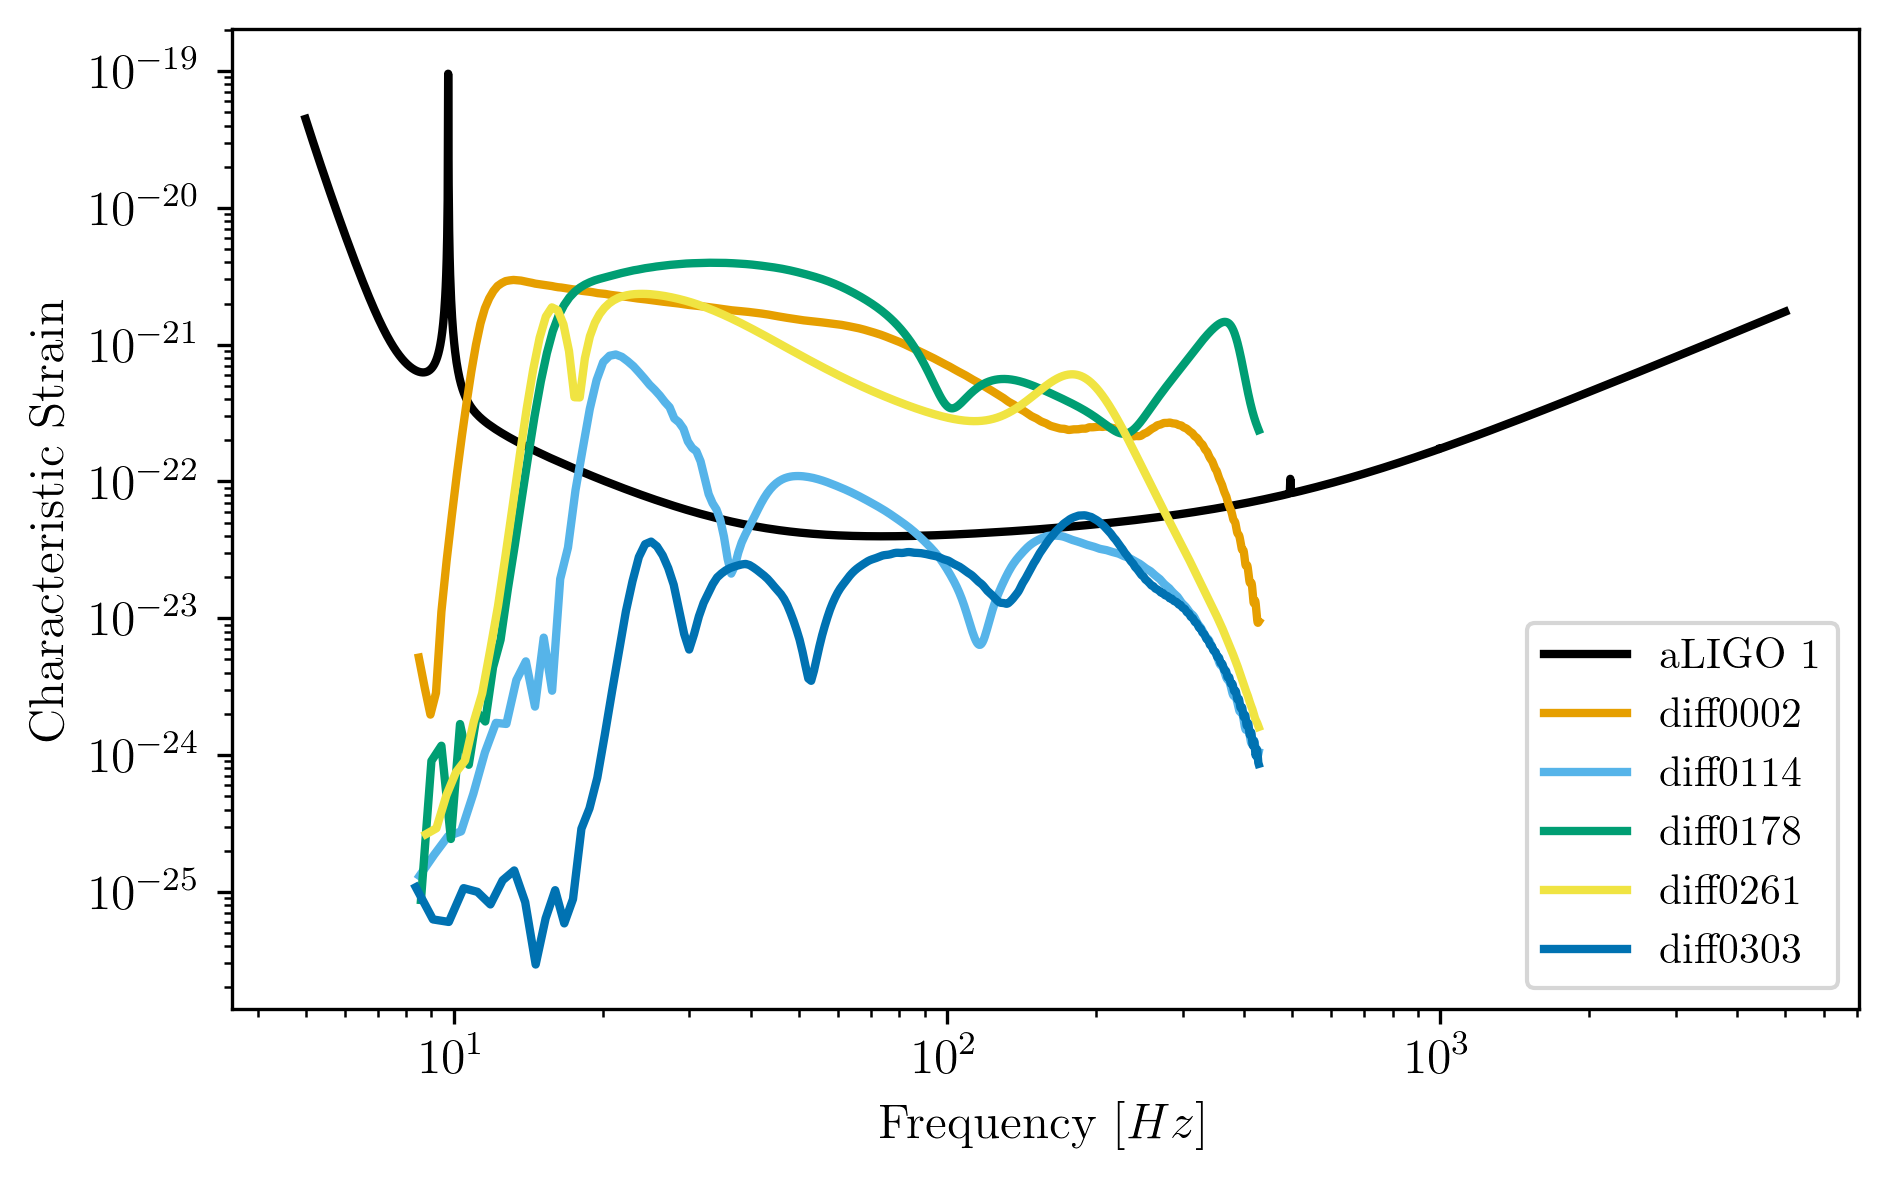

In [27]:
fig,ax = plt.subplots()
plt.loglog(aLIGO_1.fT,aLIGO_1.h_n_f,label = aLIGO_1.name)
plt.loglog(diff0002.f,binary.Get_Char_Strain(diff0002),label = 'diff0002')
plt.loglog(diff0114.f,binary.Get_Char_Strain(diff0114),label = 'diff0114')
plt.loglog(diff0178.f,binary.Get_Char_Strain(diff0178),label = 'diff0178')
plt.loglog(diff0261.f,binary.Get_Char_Strain(diff0261),label = 'diff0261')
plt.loglog(diff0303.f,binary.Get_Char_Strain(diff0303),label = 'diff0303')
plt.xlabel(r'Frequency $[Hz]$')
plt.ylabel('Characteristic Strain')
plt.legend()
plt.show()